### Import python packages

In [1]:
import pandas as pd
import numpy as np
import json
import os
import datetime as dt
from scipy.stats import iqr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

### Take a look at influencer dataset in fashion category

In [2]:
influencer_df = pd.read_csv('fashion_influencer.csv', index_col=0)
influencer_df = influencer_df.rename(columns={"Sponser": "sponsor"})

In [3]:
influencer_df.shape

(638741, 7)

In [4]:
influencer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638741 entries, 0 to 657891
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Username     638741 non-null  object 
 1   sponsor      638741 non-null  int64  
 2   json_file    638741 non-null  object 
 3   image_files  638741 non-null  object 
 4   #Followers   638741 non-null  float64
 5   #Followees   638741 non-null  float64
 6   #Posts       638741 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 39.0+ MB


In [5]:
user_df = influencer_df.groupby('Username').count()
user_df

,sponsor,json_file,image_files,#Followers,#Followees,#Posts
Username,,,,,,
1000manerasdevestir,85,85,85,85,85,85
19dreamcatcherz,9,9,9,9,9,9
1_0.8,5,5,5,5,5,5
1nonlycash,4,4,4,4,4,4
22in22,11,11,11,11,11,11
...,...,...,...,...,...,...
zsuzsubell,12,12,12,12,12,12
zubiiansarii,40,40,40,40,40,40
zurich.influencers,13,13,13,13,13,13


In [6]:
print("There are \'", user_df.shape[0], "\' influencers in the dataset")

There are ' 9290 ' influencers in the dataset


In [7]:
sponsor_post = influencer_df[['Username', 'sponsor']]
print(sponsor_post['sponsor'].value_counts())
print('non-sponsored posts ratio', sponsor_post['sponsor'].value_counts()[0]/influencer_df.shape[0])
print('sponsored posts ratio', sponsor_post['sponsor'].value_counts()[1]/influencer_df.shape[0])

0    550050
1     88691
Name: sponsor, dtype: int64
non-sponsored posts ratio 0.8611471629345854
sponsored posts ratio 0.13885283706541462


In [8]:
sponsor_info = sponsor_post.groupby('Username')['sponsor'].value_counts().unstack(fill_value=0).reset_index()
sponsor_info = sponsor_info.rename(columns={0: 'non-sponsored', 1: 'sponsored'})
sponsor_info['percentage_of_sponsored'] = sponsor_info['sponsored']/(sponsor_info['non-sponsored']+sponsor_info['sponsored'])
sponsor_info['percentage_of_sponsored'].value_counts()

0.000000    1011
0.166667     127
0.250000     123
0.142857     119
0.200000     116
            ... 
0.061069       1
0.156463       1
0.201681       1
0.546154       1
0.073593       1
Name: percentage_of_sponsored, Length: 2274, dtype: int64

In [9]:
nonsponsor_li = sponsor_info[sponsor_info['percentage_of_sponsored']==0]['Username'].tolist()
print("There are", len(nonsponsor_li), "users have no sponsored posts in our dataset:\n", nonsponsor_li)

There are 1011 users have no sponsored posts in our dataset:
 ['___noangel', '__limimi', '__niki22', '_lady.ruby_', '_lisang_', '_marinakamura_', '_martinarao_', '_maylen__', '_mihirjariwala_', '_millyna_', '_mr.gin_', '_taamiferreira', '_wildwobs', 'bestofmenstyle', 'bryanaholly', 'clothedinfaith', 'dailyfrontrow', 'dushanmilenkovich', 'elinakui', 'ellatumbless', 'elsaasiah', 'em_cullum', 'empemb', 'ericel', 'erika_n.c.r', 'eveningstandardmagazine', 'fashionista.sho', 'fifteenminfame', 'flogismondi', 'fluffileinalice', 'franniballecter', 'funkyflairboutique', 'gabrielahansolo', 'ginevralambruschi', 'glamour_doll', 'habesha_hottie', 'hannahruthsison', 'healthy_mandy', 'helenacueva', 'helenayerza', 'hello.hosnah', 'hellograciemae', 'henriquessillva', 'herzueberkopf', 'heycnyn', 'highhatgirls', 'hjsouthwood', 'hookedontilly', 'houseoftrends', 'hpluxe', 'http.edro', 'hugrunegils', 'hushglossstile', 'iambeniada', 'iamcesarin', 'iamjorgeluis_', 'iamlizacole', 'iammelody.mp', 'iammroyal', 'i

[Text(0.5, 0, 'Percentage of Sponsored Posts'),
 Text(0.5, 1.0, 'Distribution of Sponsored Post Ratio')]

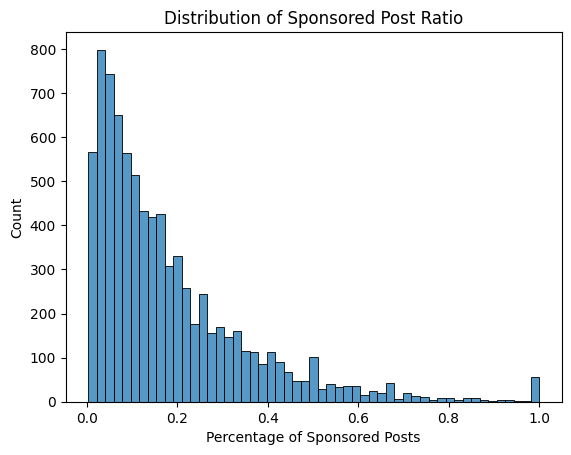

In [10]:
# Exclude those users with no sponsored post in our dataset
sponsor_user = sponsor_info[sponsor_info['percentage_of_sponsored']>0]
ax = sns.histplot(sponsor_user, x = 'percentage_of_sponsored')

ax.set(xlabel='Percentage of Sponsored Posts',
       title='Distribution of Sponsored Post Ratio')

In [11]:
# Extract posts from users that have sponsored post from the post_df
sponsor_influencer = influencer_df[~influencer_df['Username'].isin(nonsponsor_li)]
sponsor_influencer.shape

(605963, 7)

### Json preprocessing and take a look at post data

In [12]:
# dir: the directory where those json files are stored in, make sure to use the right input
# json_list: the list of json files that you want to merged (the list file name should contain '.json')
#
# One issue: the amount of comments sometimes don't fit with the lenth of edge
def process_json_files(dir, json_list):
    df_list = []
    for i in json_list:
        data = []          
        content = json.load(open(os.path.join(dir, i)))
        data.append({
            'json': i,
            'post_timestamp': content['taken_at_timestamp'],
            'likes': content['edge_media_preview_like']['count'],
            'comments': content['edge_media_to_comment']['count'],
            # 'post_text': content['edge_media_to_caption']['edges'][0]['node']['text'],
            'edge_media_to_comment': content.get('edge_media_to_comment').get('edges'),
            'edge_media_to_sponsor_user': content.get('edge_media_to_sponsor_user'),
            'edge_media_to_tagged_user': content.get('edge_media_to_tagged_user')
        })
        df_list.append(pd.DataFrame(data))
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [13]:
# Define the folder path
folder_path = "json"

# List to store all file names
all_files = []
files_name = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
  # Append all filenames to the list
  all_files.append(filename)

# Print the list of all files
for file in all_files:
  files_name.append(file)

In [14]:
# an example, more info can be added to the column if needed
post_df = process_json_files('json', files_name)
post_df

,json,post_timestamp,likes,comments,edge_media_to_comment,edge_media_to_sponsor_user,edge_media_to_tagged_user
0,1778527492682732179.json,1526237020,172,11,None,None,None
1,1944636038815427244.json,1546038702,259,6,"[{'node': {'created_at': 1546040209, 'did_repo...",{'edges': []},{'edges': [{'node': {'user': {'full_name': 'Av...
2,1919337317395337083.json,1543022859,3191,39,None,None,None
3,1973686443494832201.json,1549501780,3217,69,None,None,None
4,1687821871570856682.json,1515424067,1268,88,None,None,None
...,...,...,...,...,...,...,...
425606,1938593043369662682.json,1545318321,11094,18,"[{'node': {'created_at': 1545318570, 'did_repo...",{'edges': []},{'edges': [{'node': {'user': {'full_name': 'UN...
425607,2002986686942145187.json,1552994641,547,20,None,None,None
425608,1867448645486726111.json,1536837248,451,80,None,None,None
425609,1459428168212777165.json,1488197416,187,29,None,None,None


In [15]:
post_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425611 entries, 0 to 425610
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   json                        425611 non-null  object
 1   post_timestamp              425611 non-null  int64 
 2   likes                       425611 non-null  int64 
 3   comments                    425611 non-null  int64 
 4   edge_media_to_comment       66773 non-null   object
 5   edge_media_to_sponsor_user  66773 non-null   object
 6   edge_media_to_tagged_user   66773 non-null   object
dtypes: int64(3), object(4)
memory usage: 22.7+ MB


In [16]:
influencer_df_extracted = sponsor_influencer[['json_file', 'Username', 'sponsor','#Followers', '#Posts']]
post_df_extracted = post_df[['json', 'post_timestamp', 'likes','comments']]

### Merge influencer and post dataframe, calculate engagement rate (ER), our target feature
#### ER = (#likes + #comments) / #followers

In [17]:
merged = pd.merge(left=post_df_extracted, right=influencer_df_extracted, left_on='json', right_on='json_file')
merged

,json,post_timestamp,likes,comments,json_file,Username,sponsor,#Followers,#Posts
0,1778527492682732179.json,1526237020,172,11,1778527492682732179.json,layersnlipstick,0,3105.0,1652.0
1,1944636038815427244.json,1546038702,259,6,1944636038815427244.json,madison_silotti,0,4937.0,805.0
2,1919337317395337083.json,1543022859,3191,39,1919337317395337083.json,mrs.rebeccarobinson,0,83376.0,1468.0
3,1973686443494832201.json,1549501780,3217,69,1973686443494832201.json,thehouseofsequins,0,225990.0,2451.0
4,1687821871570856682.json,1515424067,1268,88,1687821871570856682.json,scoynex,0,34957.0,799.0
...,...,...,...,...,...,...,...,...,...
392849,1938593043369662682.json,1545318321,11094,18,1938593043369662682.json,jeromelamaar,0,232436.0,977.0
392850,2002986686942145187.json,1552994641,547,20,2002986686942145187.json,mrscocowyse,0,110414.0,4267.0
392851,1867448645486726111.json,1536837248,451,80,1867448645486726111.json,jennaleeannllc,0,9110.0,561.0
392852,1459428168212777165.json,1488197416,187,29,1459428168212777165.json,laura.lehman,0,11388.0,810.0


In [18]:
merged['ER'] = (merged['likes'] + merged['comments'])/merged['#Followers']
merged

,json,post_timestamp,likes,comments,json_file,Username,sponsor,#Followers,#Posts,ER
0,1778527492682732179.json,1526237020,172,11,1778527492682732179.json,layersnlipstick,0,3105.0,1652.0,0.058937
1,1944636038815427244.json,1546038702,259,6,1944636038815427244.json,madison_silotti,0,4937.0,805.0,0.053676
2,1919337317395337083.json,1543022859,3191,39,1919337317395337083.json,mrs.rebeccarobinson,0,83376.0,1468.0,0.038740
3,1973686443494832201.json,1549501780,3217,69,1973686443494832201.json,thehouseofsequins,0,225990.0,2451.0,0.014540
4,1687821871570856682.json,1515424067,1268,88,1687821871570856682.json,scoynex,0,34957.0,799.0,0.038791
...,...,...,...,...,...,...,...,...,...,...
392849,1938593043369662682.json,1545318321,11094,18,1938593043369662682.json,jeromelamaar,0,232436.0,977.0,0.047807
392850,2002986686942145187.json,1552994641,547,20,2002986686942145187.json,mrscocowyse,0,110414.0,4267.0,0.005135
392851,1867448645486726111.json,1536837248,451,80,1867448645486726111.json,jennaleeannllc,0,9110.0,561.0,0.058288
392852,1459428168212777165.json,1488197416,187,29,1459428168212777165.json,laura.lehman,0,11388.0,810.0,0.018967


In [66]:
COLUMN = ['post_timestamp', 'likes', 'comments', 'sponsor', 'ER', '#Followers', '#Posts', 'json']
df_ = merged[COLUMN]

In [69]:
# Check data types and missing values
print(df_.info())

# Descriptive statistics for numerical columns
print(df_.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392854 entries, 0 to 392853
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   post_timestamp  392854 non-null  int64  
 1   likes           392854 non-null  int64  
 2   comments        392854 non-null  int64  
 3   sponsor         392854 non-null  int64  
 4   ER              392854 non-null  float64
 5   #Followers      392854 non-null  float64
 6   #Posts          392854 non-null  float64
 7   json            392854 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 27.0+ MB
None
       post_timestamp         likes       comments        sponsor  \
count    3.928540e+05  3.928540e+05  392854.000000  392854.000000   
mean     1.531968e+09  4.964705e+03      90.621198       0.145935   
std      1.786186e+07  3.838957e+04     799.429864       0.353041   
min      1.350679e+09  0.000000e+00       0.000000       0.000000   
25%      1.523389

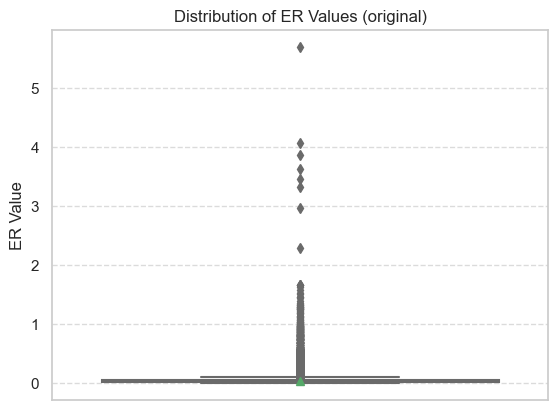

In [70]:
# Assuming your DataFrame is named 'df_'
sns.set_style("whitegrid")  # Set a background grid for better readability

sns.boxplot(
    y="ER",
    data=df_,
    showmeans=True,  # Show the mean as a marker within the box
    palette="Set3",  # Use a color palette from available options (check Seaborn documentation)
)

plt.title("Distribution of ER Values (original)")
plt.ylabel("ER Value")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add a dashed grid on the y-axis

# Display the plot
plt.show()

In [71]:
print('outliers:')
print(df_[df_['ER']>2].sort_values('ER', ascending=False))
# remove outliers
df = df_[df_['ER']<2]

outliers:
        post_timestamp   likes  comments  sponsor        ER  #Followers  \
287800      1553147791   16156         5        1  5.692497      2839.0   
109838      1550097814  185413       313        0  4.074636     45581.0   
245809      1554497991    4640        44        0  3.871074      1210.0   
267347      1521415048   50076       207        0  3.633690     13838.0   
329724      1549583437  157109       241        0  3.452096     45581.0   
132950      1547842236  111001       139        0  3.321379     33462.0   
199801      1549653392  121265       776        0  2.966625     41138.0   
55648       1548864385   32529       437        0  2.293447     14374.0   

        #Posts                      json  
287800   665.0  2004271399983711731.json  
109838  1057.0  1978686339387173342.json  
245809   620.0  2015597700411300611.json  
267347   472.0  1738077857361866546.json  
329724  1057.0  1974371433720432329.json  
132950  2951.0  1959765183220327332.json  
199801  1194.

In [72]:
print('ER=0:')
print(df[df['ER']==0])
# remove outliers
df = df[df['ER']>0]

ER=0:
        post_timestamp  likes  comments  sponsor   ER  #Followers  #Posts  \
67999       1536198345      0         0        0  0.0      3262.0   820.0   
132541      1553643970      0         0        0  0.0      1131.0  1598.0   

                            json  
67999   1862089139383862797.json  
132541  2008433647966794706.json  


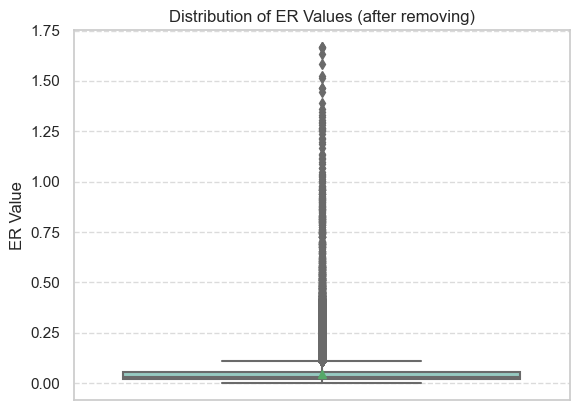

In [73]:
# Assuming your DataFrame is named 'df_'
sns.set_style("whitegrid")  # Set a background grid for better readability

sns.boxplot(
    y="ER",
    data=df,
    showmeans=True,  # Show the mean as a marker within the box
    palette="Set3",  # Use a color palette from available options (check Seaborn documentation)
)

plt.title("Distribution of ER Values (after removing)")
plt.ylabel("ER Value")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add a dashed grid on the y-axis

# Display the plot
plt.show()

----

In [74]:
# temp = pd.read_csv('data_w_time_feature.csv')

In [695]:
temp = pd.read_csv('image_er_text_removed.csv')

In [696]:
merged_temp = pd.merge(left=df, right=temp, left_on='json', right_on='json_file')

In [697]:
merged_temp = merged_temp.query("ER_x > 0 & ER_x < 2")

In [698]:
rag = 1.5*iqr(merged_temp['ER_x'])
# merged_temp[merged_temp['ER']<np.quantile(merged_temp['ER'], 0.25)-rag]
print('upper bound:', np.quantile(merged_temp['ER_x'], 0.75)+rag)
print('number of data points>upper bound:', merged_temp[merged_temp['ER_x']>np.quantile(merged_temp['ER_x'], 0.75)+rag].shape[0])
print('number of data points<upper bound:', merged_temp[merged_temp['ER_x']<np.quantile(merged_temp['ER_x'], 0.75)+rag].shape[0])

upper bound: 0.11260761857648055
number of data points>upper bound: 3718
number of data points<upper bound: 53594


In [704]:
rag = 1.5*iqr(merged_temp['ER_x'])
upper_bound = np.quantile(merged_temp['ER_x'], 0.75)+rag
n_outlier = merged_temp[merged_temp['ER_x']>np.quantile(merged_temp['ER_x'], 0.75)+rag].shape[0]
n_inlier = merged_temp[merged_temp['ER_x']<np.quantile(merged_temp['ER_x'], 0.75)+rag].shape[0]

In [708]:
inliers = merged_temp[merged_temp['ER_x'] <= upper_bound]
outliers = merged_temp[merged_temp['ER_x'] > upper_bound]

merged_temp.loc[inliers.index, 'weight'] = 1 / n_inlier
merged_temp.loc[outliers.index, 'weight'] = 1 / n_outlier

In [715]:
merged_temp.to_csv('post_time_features.csv', lineterminator = "\r\n", index = False)

----

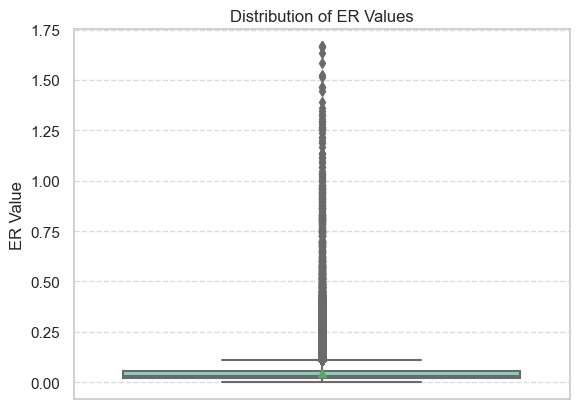

In [75]:
# Assuming your DataFrame is named 'df_'
sns.set_style("whitegrid")  # Set a background grid for better readability

sns.boxplot(
    y="ER",
    data=df,
    showmeans=True,  # Show the mean as a marker within the box
    palette="Set3",  # Use a color palette from available options (check Seaborn documentation)
)

# Customize title, labels, and grid (optional)
plt.title("Distribution of ER Values")
plt.ylabel("ER Value")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add a dashed grid on the y-axis

# Display the plot
plt.show()

### Add time features and analize them

In [76]:
# Convert timestamp to datetime
# df['post_timestamp'] = pd.to_datetime(df['post_timestamp'])
df['post_timestamp'] = df['post_timestamp'].apply(lambda d:dt.datetime.fromtimestamp(d).strftime('%Y-%m-%d %H:%M:%S'))
df['post_timestamp'] = pd.to_datetime(df['post_timestamp'])

# Extract year, month, day, hour
df['year'] = df['post_timestamp'].dt.year
df['month'] = df['post_timestamp'].dt.month
df['day'] = df['post_timestamp'].dt.day
df['hour'] = df['post_timestamp'].dt.hour

df['weekday'] = df['post_timestamp'].dt.weekday+1

df

,post_timestamp,likes,comments,sponsor,ER,#Followers,#Posts,json,year,month,day,hour,weekday
0,2018-05-13 14:43:40,172,11,0,0.058937,3105.0,1652.0,1778527492682732179.json,2018,5,13,14,7
1,2018-12-28 18:11:42,259,6,0,0.053676,4937.0,805.0,1944636038815427244.json,2018,12,28,18,5
2,2018-11-23 20:27:39,3191,39,0,0.038740,83376.0,1468.0,1919337317395337083.json,2018,11,23,20,5
3,2019-02-06 20:09:40,3217,69,0,0.014540,225990.0,2451.0,1973686443494832201.json,2019,2,6,20,3
4,2018-01-08 10:07:47,1268,88,0,0.038791,34957.0,799.0,1687821871570856682.json,2018,1,8,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
392849,2018-12-20 10:05:21,11094,18,0,0.047807,232436.0,977.0,1938593043369662682.json,2018,12,20,10,4
392850,2019-03-19 07:24:01,547,20,0,0.005135,110414.0,4267.0,2002986686942145187.json,2019,3,19,7,2
392851,2018-09-13 07:14:08,451,80,0,0.058288,9110.0,561.0,1867448645486726111.json,2018,9,13,7,4
392852,2017-02-27 07:10:16,187,29,0,0.018967,11388.0,810.0,1459428168212777165.json,2017,2,27,7,1


### Exploratory data analysis and visualization

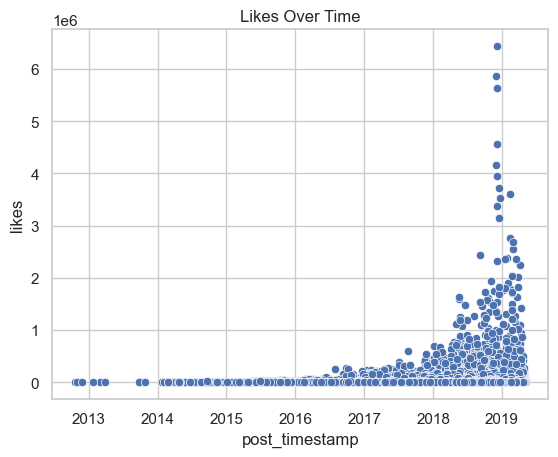

In [77]:
# Time series plot
sns.scatterplot(x='post_timestamp', y='likes', data=df)
plt.title('Likes Over Time')
plt.grid(True)
plt.show()

In [78]:
toplike = df.sort_values(by='likes', ascending=False).head(100)
toplike

,post_timestamp,likes,comments,sponsor,ER,#Followers,#Posts,json,year,month,day,hour,weekday
218545,2018-12-04 07:36:17,6435680,58870,0,0.226827,28632169.0,2638.0,1926921609942063242.json,2018,12,4,7,2
123970,2018-12-01 10:31:57,5854953,60291,0,0.206594,28632169.0,2638.0,1924835697712157515.json,2018,12,1,10,6
352702,2018-12-04 07:35:14,5628253,42360,0,0.198050,28632169.0,2638.0,1926921081870720357.json,2018,12,4,7,2
26495,2018-12-04 10:12:50,4564501,74667,0,0.162026,28632169.0,2638.0,1927000398055286221.json,2018,12,4,10,2
100725,2018-12-02 07:57:01,4154532,38465,0,0.146444,28632169.0,2638.0,1925482487188644980.json,2018,12,2,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
339843,2018-07-12 21:27:05,820391,3060,0,0.028760,28632169.0,2638.0,1822217083539277854.json,2018,7,12,21,4
166430,2018-11-09 18:22:37,810701,10616,0,0.161854,5074442.0,5127.0,1909127527734177336.json,2018,11,9,18,5
279211,2019-03-19 12:13:56,797800,1823,0,0.027927,28632169.0,2638.0,2003132608113787652.json,2019,3,19,12,2
118089,2018-05-27 16:36:43,790472,5154,0,0.071733,11091509.0,1632.0,1788731250262357116.json,2018,5,27,16,7


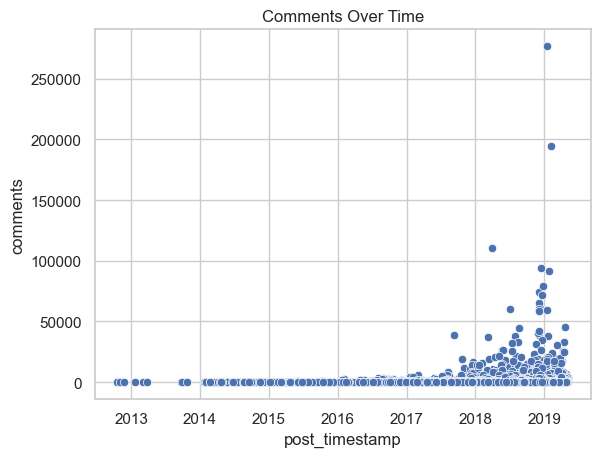

In [79]:
# Time series plot
sns.scatterplot(x='post_timestamp', y='comments', data=df)
plt.title('Comments Over Time')
plt.grid(True)
plt.show()

In [80]:
topcomment = df.sort_values(by='comments', ascending=False).head(100)
topcomment

,post_timestamp,likes,comments,sponsor,ER,#Followers,#Posts,json,year,month,day,hour,weekday
267315,2019-01-15 14:48:23,98271,276875,0,0.743172,504790.0,934.0,1957579673156424266.json,2019,1,15,14,2
182150,2019-02-04 13:53:01,25967,194996,1,1.465816,150744.0,1457.0,1972047318845521067.json,2019,2,4,13,1
168726,2018-03-27 16:49:18,174440,110194,0,0.044268,6429723.0,1441.0,1744526266885063243.json,2018,3,27,16,2
43509,2018-12-13 15:16:27,175118,94379,0,0.098901,2724909.0,1104.0,1933676196988359131.json,2018,12,13,15,4
293424,2019-01-28 13:50:42,18048,91601,0,0.727386,150744.0,1457.0,1966972719128703073.json,2019,1,28,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186511,2019-01-09 15:18:12,7678,12374,0,0.218351,91834.0,1740.0,1953246026366331971.json,2019,1,9,15,3
178291,2018-12-15 15:00:54,4935,12317,0,0.340572,50656.0,3027.0,1935117923791948250.json,2018,12,15,15,6
348782,2018-11-27 15:59:18,11609,12148,0,0.208844,113755.0,2521.0,1922101352440348418.json,2018,11,27,15,2
375950,2018-12-18 16:25:59,34188,11789,0,0.063210,727367.0,2495.0,1937335070398661269.json,2018,12,18,16,2


/var/folders/c_/6jt_vlf55f91p67q18x96hlr0000gn/T/ipykernel_1357/872368546.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='post_timestamp', y='ER', data=df, palette="Set2")


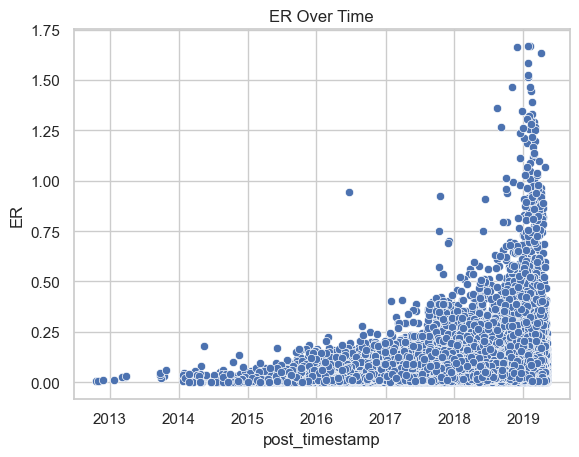

In [81]:
# Time series plot
sns.scatterplot(x='post_timestamp', y='ER', data=df, palette="Set2")
plt.title('ER Over Time')
plt.grid(True)
plt.show()

In [82]:
topER = df.sort_values(by='ER', ascending=False).head(100)
topER

,post_timestamp,likes,comments,sponsor,ER,#Followers,#Posts,json,year,month,day,hour,weekday
81586,2019-02-06 20:19:15,7575,614,1,1.667481,4911.0,130.0,1973691269452645660.json,2019,2,6,20,3
321185,2019-01-26 12:00:44,8009,7,0,1.667221,4808.0,395.0,1965467822121722247.json,2019,1,26,12,6
347858,2018-12-01 06:02:36,7179,15334,0,1.664055,13529.0,1685.0,1924700129787239949.json,2018,12,1,6,6
241359,2019-04-05 14:27:01,14214,363,0,1.635293,8914.0,496.0,2015520779308328286.json,2019,4,5,14,5
338684,2019-01-27 20:18:37,7290,488,0,1.583791,4911.0,130.0,1966443187904764829.json,2019,1,27,20,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88707,2019-03-18 15:00:23,3785,277,0,0.827123,4911.0,130.0,2002491605994565786.json,2019,3,18,15,1
121875,2019-04-01 15:05:07,3786,265,0,0.824883,4911.0,130.0,2012640851088314828.json,2019,4,1,15,1
336252,2019-03-21 15:20:26,3740,307,0,0.824068,4911.0,130.0,2004676028290680925.json,2019,3,21,15,4
186948,2019-01-13 18:55:36,2597,218,0,0.821179,3428.0,773.0,1956254544876185854.json,2019,1,13,18,7


In [83]:
# weekdays = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
# df_['weekday_'] = df_['weekday'].map(weekdays)

In [84]:
# sns.set(font_scale=1)

# fig, ax = plt.subplots(4, 1, figsize=(10, 4*6))

# sns.histplot(data=df, x="year", ax=ax[0])
# ax[0].title.set_text('Histogram of year')

# sns.histplot(data=df, x="month", ax=ax[1])
# ax[1].title.set_text('Histogram of month')

# sns.histplot(data=df, x="day", ax=ax[2])
# ax[2].title.set_text('Histogram of day')

# sns.histplot(data=df, x="weekday", ax=ax[3])
# ax[3].title.set_text('Histogram of weekday')

# plt.show()

In [85]:
# sns.set(font_scale=1)

# fig, ax = plt.subplots(5, 1, figsize=(10, 5*6))

# sns.barplot(x=df_.year, y=df_.likes, ax=ax[0], palette='Blues')
# ax[0].title.set_text('Distribution of likes for each post by years')

# sns.barplot(x=df_.month, y=df_.likes, ax=ax[1], palette='Blues')
# ax[1].title.set_text('Distribution of likes for each post by months')

# sns.barplot(x=df_.day, y=df_.likes, ax=ax[2], palette='Blues')
# ax[2].title.set_text('Distribution of likes for each post by days')

# sns.barplot(x=df_.hour, y=df_.likes, ax=ax[3], palette='Blues')
# ax[3].title.set_text('Distribution of likes for each post by hours')

# sns.barplot(x=df_.weekday, y=df_.likes, ax=ax[4], palette='Blues')
# ax[4].title.set_text('Distribution of likes for each post by weekdays')

# plt.show()

In [86]:
# sns.set(font_scale=1)

# fig, ax = plt.subplots(5, 1, figsize=(10, 5*6))

# sns.barplot(x=df_.year, y=df_.comments, ax=ax[0], palette='Blues')
# ax[0].title.set_text('Distribution of comments for each post by years')

# sns.barplot(x=df_.month, y=df_.comments, ax=ax[1], palette='Blues')
# ax[1].title.set_text('Distribution of comments for each post by months')

# sns.barplot(x=df_.day, y=df_.comments, ax=ax[2], palette='Blues')
# ax[2].title.set_text('Distribution of comments for each post by days')

# sns.barplot(x=df_.hour, y=df_.comments, ax=ax[3], palette='Blues')
# ax[3].title.set_text('Distribution of comments for each post by hours')

# sns.barplot(x=df_.weekday, y=df_.comments, ax=ax[4], palette='Blues')
# ax[4].title.set_text('Distribution of comments for each post by weekdays')

# plt.show()

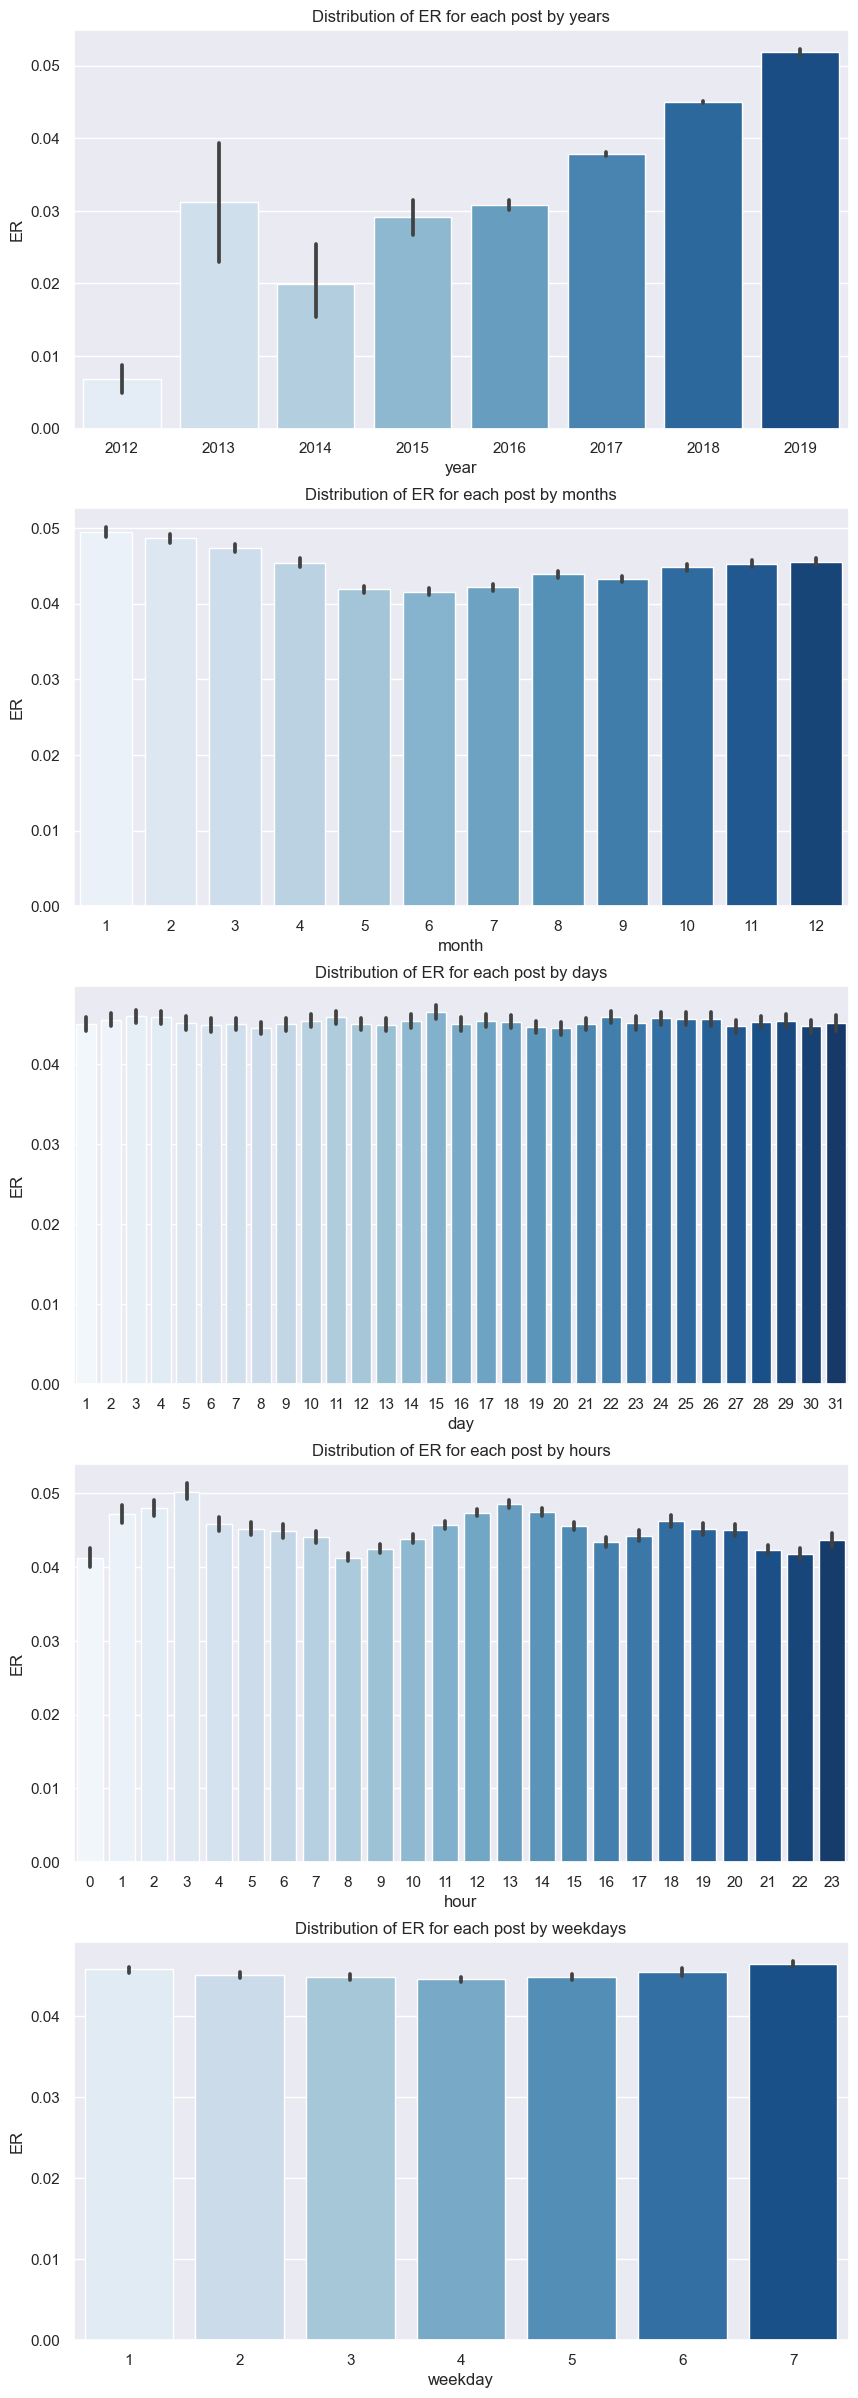

In [87]:
sns.set(font_scale=1)

fig, ax = plt.subplots(5, 1, figsize=(10, 5*6))

sns.barplot(x=df.year, y=df.ER, ax=ax[0], palette='Blues')
ax[0].title.set_text('Distribution of ER for each post by years')

sns.barplot(x=df.month, y=df.ER, ax=ax[1], palette='Blues')
ax[1].title.set_text('Distribution of ER for each post by months')

sns.barplot(x=df.day, y=df.ER, ax=ax[2], palette='Blues')
ax[2].title.set_text('Distribution of ER for each post by days')

sns.barplot(x=df.hour, y=df.ER, ax=ax[3], palette='Blues')
ax[3].title.set_text('Distribution of ER for each post by hours')

sns.barplot(x=df.weekday, y=df.ER, ax=ax[4], palette='Blues')
ax[4].title.set_text('Distribution of ER for each post by weekdays')


plt.show()

In [88]:
# defining the table
EXAMINE_COLUMN =['year', 'ER']
df_chi = df[EXAMINE_COLUMN]
stat, p, dof, expected = chi2_contingency(df_chi)
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print(EXAMINE_COLUMN, 'Dependent (reject H0)')
else:
    print(EXAMINE_COLUMN, 'Independent (H0 holds true)')


p value is 1.0
['year', 'ER'] Independent (H0 holds true)


In [89]:
# defining the table
EXAMINE_COLUMN =['month', 'ER']
df_chi = df[EXAMINE_COLUMN]
stat, p, dof, expected = chi2_contingency(df_chi)
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print(EXAMINE_COLUMN, 'Dependent (reject H0)')
else:
    print(EXAMINE_COLUMN, 'Independent (H0 holds true)')


p value is 1.0
['month', 'ER'] Independent (H0 holds true)


In [90]:
# defining the table
EXAMINE_COLUMN =['day', 'ER']
df_chi = df[EXAMINE_COLUMN]
stat, p, dof, expected = chi2_contingency(df_chi)
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print(EXAMINE_COLUMN, 'Dependent (reject H0)')
else:
    print(EXAMINE_COLUMN, 'Independent (H0 holds true)')

p value is 1.0
['day', 'ER'] Independent (H0 holds true)


In [91]:
# defining the table
EXAMINE_COLUMN =['hour', 'ER']
df_chi = df[EXAMINE_COLUMN]
stat, p, dof, expected = chi2_contingency(df_chi)
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print(EXAMINE_COLUMN, 'Dependent (reject H0)')
else:
    print(EXAMINE_COLUMN, 'Independent (H0 holds true)')

p value is 1.0
['hour', 'ER'] Independent (H0 holds true)


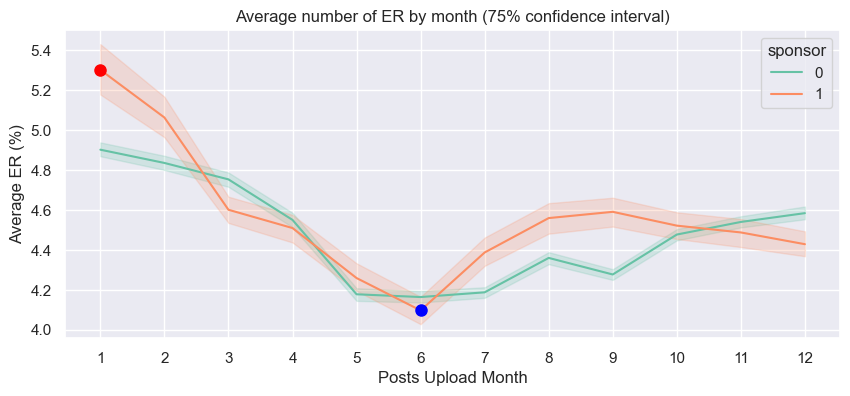

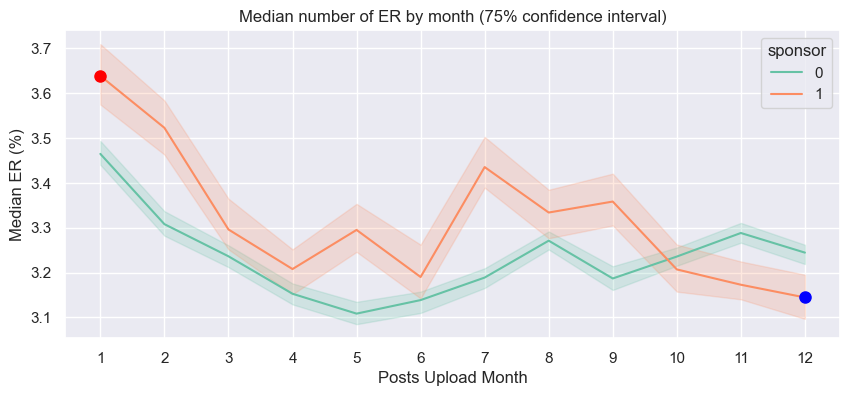

In [125]:
def plot_agg_simple(agg_name="Average", agg_function=np.mean, ci = 75):
    # STEP = 0.1
    plt.figure(figsize=(10, 4))

    df_er = df.copy()
    df_er['ER'] = 100*df_er['ER']
    ax = sns.lineplot(data=df_er, x='month', y='ER', estimator=agg_function, errorbar=('ci', ci), hue='sponsor', palette="Set2")
    frame = df_er[df_er['sponsor']==1].groupby('month')['ER'].apply(agg_function)

    plt.plot(frame.argmax()+1, frame.max(), color='red', markersize=8, marker='o')
    plt.plot(frame.argmin()+1, frame.min(), color='blue', markersize=8, marker='o')

    ax.set(xlabel='Posts Upload Month',
       ylabel=f'{agg_name} ER (%)',
       title=f'{agg_name} number of ER by month ({ci}% confidence interval)',
       xticks = range(1, 13)
    )
    plt.show()

plot_agg_simple(agg_name="Average", agg_function=np.mean, ci=75)
plot_agg_simple(agg_name="Median", agg_function=np.median, ci=75)

In [93]:
def get_season(month):
  """
  This function takes a month number (1-12) and returns the corresponding season.
  """
  if month in [3, 4, 5]:
    return "Spring"
  elif month in [6, 7, 8]:
    return "Summer"
  elif month in [9, 10, 11]:
    return "Fall"
  else:
    return "Winter"

df['season'] = df['month'].apply(get_season)
df

,post_timestamp,likes,comments,sponsor,ER,#Followers,#Posts,json,year,month,day,hour,weekday,season
0,2018-05-13 14:43:40,172,11,0,0.058937,3105.0,1652.0,1778527492682732179.json,2018,5,13,14,7,Spring
1,2018-12-28 18:11:42,259,6,0,0.053676,4937.0,805.0,1944636038815427244.json,2018,12,28,18,5,Winter
2,2018-11-23 20:27:39,3191,39,0,0.038740,83376.0,1468.0,1919337317395337083.json,2018,11,23,20,5,Fall
3,2019-02-06 20:09:40,3217,69,0,0.014540,225990.0,2451.0,1973686443494832201.json,2019,2,6,20,3,Winter
4,2018-01-08 10:07:47,1268,88,0,0.038791,34957.0,799.0,1687821871570856682.json,2018,1,8,10,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392849,2018-12-20 10:05:21,11094,18,0,0.047807,232436.0,977.0,1938593043369662682.json,2018,12,20,10,4,Winter
392850,2019-03-19 07:24:01,547,20,0,0.005135,110414.0,4267.0,2002986686942145187.json,2019,3,19,7,2,Spring
392851,2018-09-13 07:14:08,451,80,0,0.058288,9110.0,561.0,1867448645486726111.json,2018,9,13,7,4,Fall
392852,2017-02-27 07:10:16,187,29,0,0.018967,11388.0,810.0,1459428168212777165.json,2017,2,27,7,1,Winter


In [94]:
# # defining the table
# EXAMINE_COLUMN =['season', 'ER']
# df_chi = df_[EXAMINE_COLUMN]
# season_mapping = {"Spring": 1, "Summer": 2, "Fall": 3, "Winter": 4}
# df_chi['season'].replace(season_mapping, inplace=True)
# stat, p, dof, expected = chi2_contingency(df_chi)
# # interpret p-value
# alpha = 0.05
# print("p value is " + str(p))
# if p <= alpha:
#     print(EXAMINE_COLUMN, 'Dependent (reject H0)')
# else:
#     print(EXAMINE_COLUMN, 'Independent (H0 holds true)')

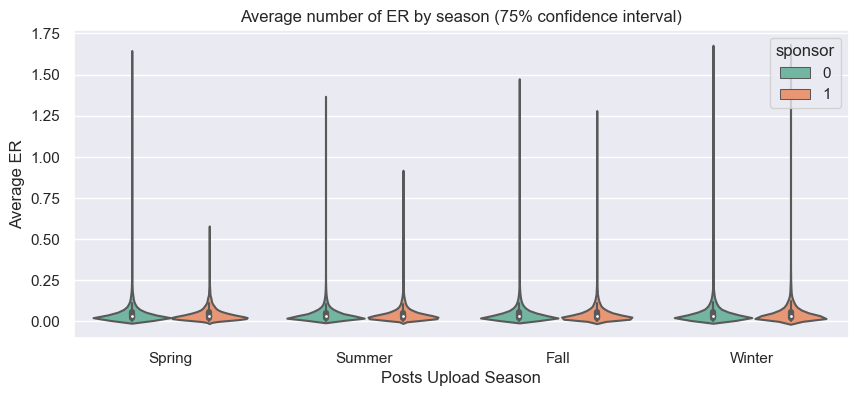

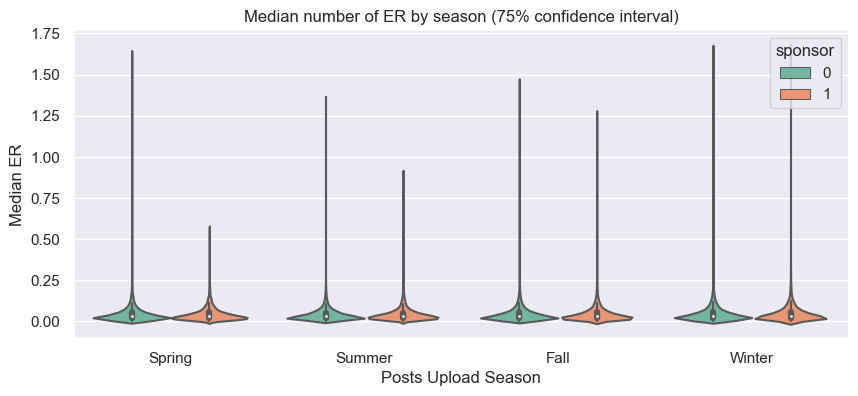

In [146]:
def plot_agg_simple(agg_name="Average", agg_function=np.mean, ci = 75):
    
    plt.figure(figsize=(10, 4))

    ax = sns.violinplot(x="season", y="ER", hue="sponsor", showmeans=True, data=df, palette="Set2",  order=["Spring", "Summer", "Fall", "Winter"])
    ax.set(xlabel='Posts Upload Season',
       ylabel=f'{agg_name} ER',
       title=f'{agg_name} number of ER by season ({ci}% confidence interval)'
    )
    
    plt.show()

plot_agg_simple(agg_name="Average", agg_function=np.mean, ci=75)
plot_agg_simple(agg_name="Median", agg_function=np.median, ci=75)

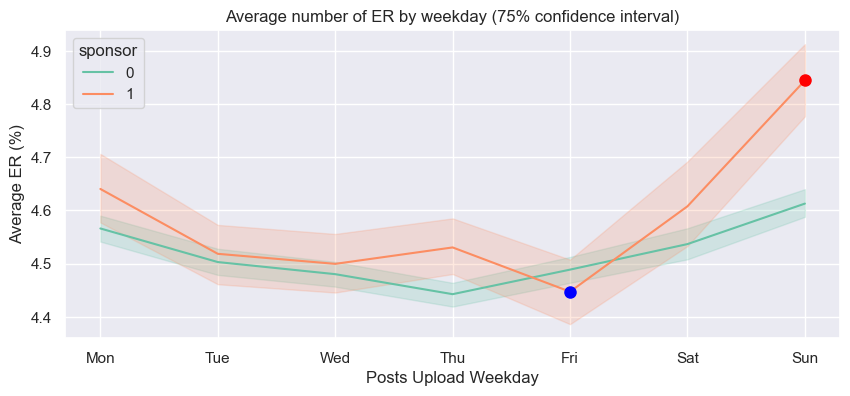

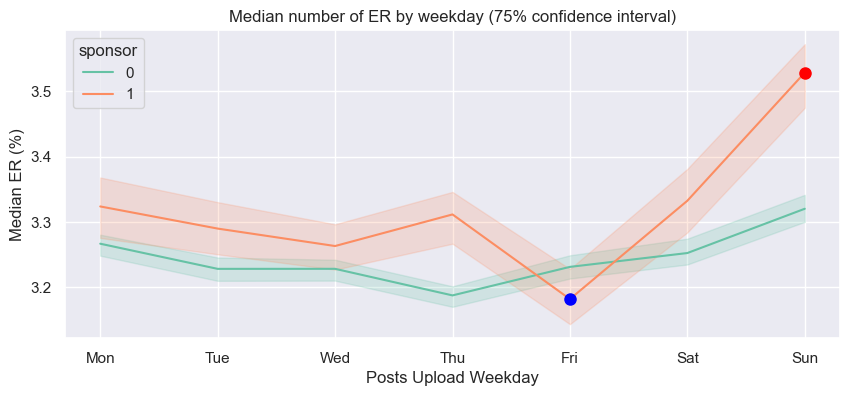

In [126]:
def plot_agg_simple(agg_name="Average", agg_function=np.mean, ci = 75):

    plt.figure(figsize=(10, 4))
    df_er = df.copy()
    df_er['ER'] = 100*df_er['ER']

    ax = sns.lineplot(data=df_er, x='weekday', y='ER', estimator=agg_function, errorbar=('ci', ci), color='#A788B5', hue='sponsor', palette="Set2")
    frame = df_er[df_er['sponsor']==1].groupby('weekday')['ER'].apply(agg_function)

    plt.plot(frame.argmax()+1, frame.max(), color='red', markersize=8, marker='o')
    plt.plot(frame.argmin()+1, frame.min(), color='blue', markersize=8, marker='o')

    ax.set(xlabel='Posts Upload Weekday',
       ylabel=f'{agg_name} ER (%)',
       title=f'{agg_name} number of ER by weekday ({ci}% confidence interval)',
       xticks = range(1, 8),
       xticklabels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    )
    plt.show()

plot_agg_simple(agg_name="Average", agg_function=np.mean, ci=75)
plot_agg_simple(agg_name="Median", agg_function=np.median, ci=75)

In [97]:
def categorize_hour(hour):
  """
  This function takes an hour value and returns the corresponding category.
  """
  if hour in range(0,3):
    return '0-3'
  elif hour in range(3,6):
    return '3-6'
  elif hour in range(6,9):
    return '6-9'
  elif hour in range(9,12):
    return '9-12'
  elif hour in range(12,15):
    return '12-15'
  elif hour in range(15,18):
    return '15-18'
  elif hour in range(18,21):
    return '18-21'
  else:
    return '21-24'

df['hour_category'] = df['hour'].apply(categorize_hour)
df

,post_timestamp,likes,comments,sponsor,ER,#Followers,#Posts,json,year,month,day,hour,weekday,season,hour_category
0,2018-05-13 14:43:40,172,11,0,0.058937,3105.0,1652.0,1778527492682732179.json,2018,5,13,14,7,Spring,12-15
1,2018-12-28 18:11:42,259,6,0,0.053676,4937.0,805.0,1944636038815427244.json,2018,12,28,18,5,Winter,18-21
2,2018-11-23 20:27:39,3191,39,0,0.038740,83376.0,1468.0,1919337317395337083.json,2018,11,23,20,5,Fall,18-21
3,2019-02-06 20:09:40,3217,69,0,0.014540,225990.0,2451.0,1973686443494832201.json,2019,2,6,20,3,Winter,18-21
4,2018-01-08 10:07:47,1268,88,0,0.038791,34957.0,799.0,1687821871570856682.json,2018,1,8,10,1,Winter,9-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392849,2018-12-20 10:05:21,11094,18,0,0.047807,232436.0,977.0,1938593043369662682.json,2018,12,20,10,4,Winter,9-12
392850,2019-03-19 07:24:01,547,20,0,0.005135,110414.0,4267.0,2002986686942145187.json,2019,3,19,7,2,Spring,6-9
392851,2018-09-13 07:14:08,451,80,0,0.058288,9110.0,561.0,1867448645486726111.json,2018,9,13,7,4,Fall,6-9
392852,2017-02-27 07:10:16,187,29,0,0.018967,11388.0,810.0,1459428168212777165.json,2017,2,27,7,1,Winter,6-9


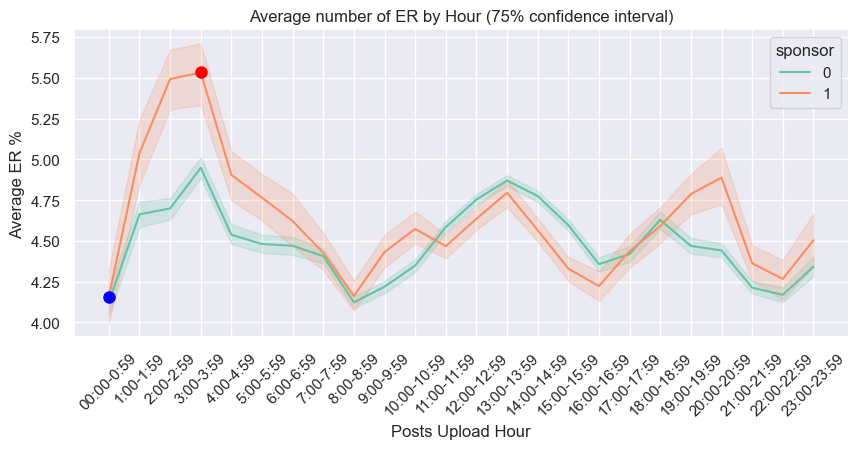

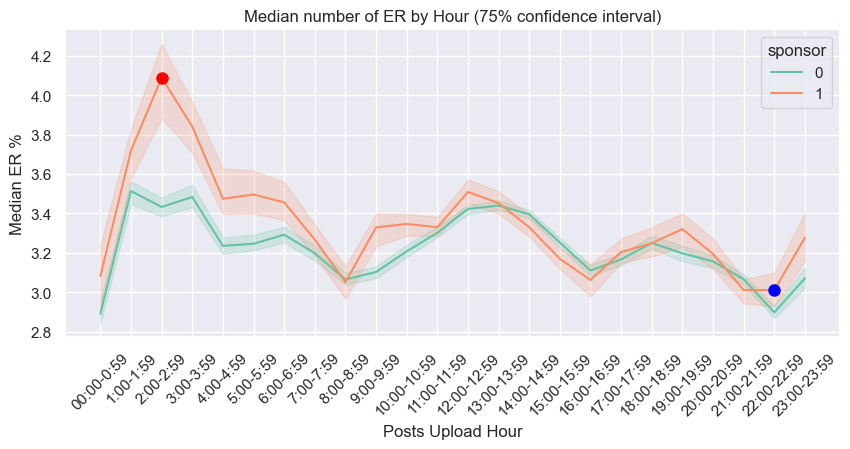

In [128]:
def plot_agg_simple(agg_name="Average", agg_function=np.mean, ci = 75):
    plt.figure(figsize=(10, 4))
    df_er = df.copy()
    df_er['ER'] = 100*df_er['ER']

    ax = sns.lineplot(data=df_er, x='hour', y='ER', estimator=agg_function, errorbar=('ci', ci), color='#A788B5', hue='sponsor', palette="Set2")
    frame = df_er[df_er['sponsor']==1].groupby('hour')['ER'].apply(agg_function)

    plt.plot(frame.argmax(), frame.max(), color='red', markersize=8, marker='o')
    plt.plot(frame.argmin(), frame.min(), color='blue', markersize=8, marker='o')

    ax.set(xlabel='Posts Upload Hour',
       ylabel=f'{agg_name} ER %',
       title=f'{agg_name} number of ER by Hour ({ci}% confidence interval)',
       xticks = range(24),
       xticklabels = ['00:00-0:59', '1:00-1:59', '2:00-2:59', '3:00-3:59', '4:00-4:59', '5:00-5:59', '6:00-6:59',
                       '7:00-7:59', '8:00-8:59', '9:00-9:59', '10:00-10:59', '11:00-11:59', '12:00-12:59', 
                       '13:00-13:59', '14:00-14:59', '15:00-15:59', '16:00-16:59', '17:00-17:59', '18:00-18:59', 
                       '19:00-19:59', '20:00-20:59', '21:00-21:59', '22:00-22:59', '23:00-23:59']
    )
    plt.xticks(rotation=45)
    plt.show()

plot_agg_simple(agg_name="Average", agg_function=np.mean, ci=75)
plot_agg_simple(agg_name="Median", agg_function=np.median, ci=75)

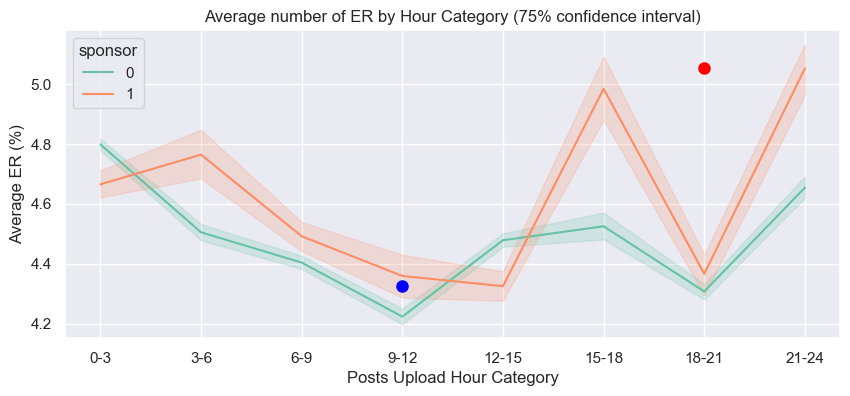

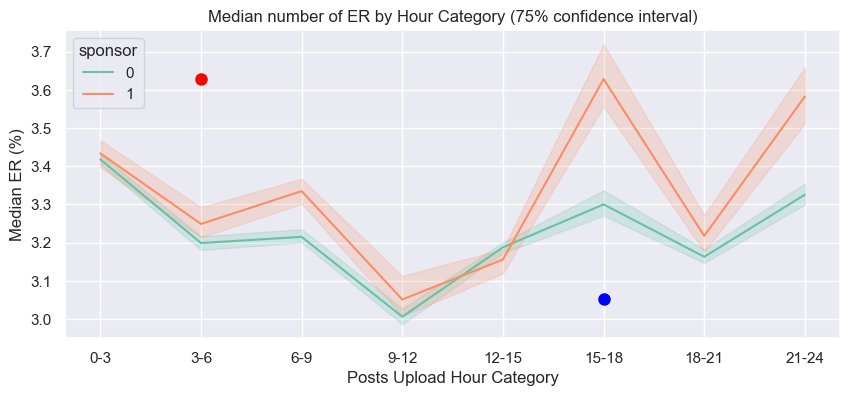

In [133]:
def plot_agg_simple(agg_name="Average", agg_function=np.mean, ci = 75):

    plt.figure(figsize=(10, 4))
    df_er = df.copy()
    df_er['ER'] = 100*df_er['ER']

    ax = sns.lineplot(data=df_er, x='hour_category', y='ER', estimator=agg_function, errorbar=('ci', ci), color='#A788B5', hue='sponsor', palette="Set2")
    # frame = df_er[df_er['sponsor']==1].groupby('hour_category')['ER'].apply(agg_function)

    # plt.plot(frame.argmax()+1, frame.max(), color='red', markersize=8, marker='o')
    # plt.plot(frame.argmin()+1, frame.min(), color='blue', markersize=8, marker='o')

    ax.set(xlabel='Posts Upload Hour Category',
       ylabel=f'{agg_name} ER (%)',
       title=f'{agg_name} number of ER by Hour Category ({ci}% confidence interval)',
       xticks = range(8),
       xticklabels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
    )

    plt.show()

plot_agg_simple(agg_name="Average", agg_function=np.mean, ci=75)
plot_agg_simple(agg_name="Median", agg_function=np.median, ci=75)

In [99]:
def working_hours(row):
  """
  This function takes a row of the DataFrame and returns "working_hour" or "non_working_hour" based on weekday and hour.
  """
  if (row['weekday'] in range(1, 6)) & (8 <= row['hour'] < 18):
    return 'working_hour'
  else:
    return 'non_working_hour'

df['working_hour_status'] = df.apply(working_hours, axis=1)
df

,post_timestamp,likes,comments,sponsor,ER,#Followers,#Posts,json,year,month,day,hour,weekday,season,hour_category,working_hour_status
0,2018-05-13 14:43:40,172,11,0,0.058937,3105.0,1652.0,1778527492682732179.json,2018,5,13,14,7,Spring,12-15,non_working_hour
1,2018-12-28 18:11:42,259,6,0,0.053676,4937.0,805.0,1944636038815427244.json,2018,12,28,18,5,Winter,18-21,non_working_hour
2,2018-11-23 20:27:39,3191,39,0,0.038740,83376.0,1468.0,1919337317395337083.json,2018,11,23,20,5,Fall,18-21,non_working_hour
3,2019-02-06 20:09:40,3217,69,0,0.014540,225990.0,2451.0,1973686443494832201.json,2019,2,6,20,3,Winter,18-21,non_working_hour
4,2018-01-08 10:07:47,1268,88,0,0.038791,34957.0,799.0,1687821871570856682.json,2018,1,8,10,1,Winter,9-12,working_hour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392849,2018-12-20 10:05:21,11094,18,0,0.047807,232436.0,977.0,1938593043369662682.json,2018,12,20,10,4,Winter,9-12,working_hour
392850,2019-03-19 07:24:01,547,20,0,0.005135,110414.0,4267.0,2002986686942145187.json,2019,3,19,7,2,Spring,6-9,non_working_hour
392851,2018-09-13 07:14:08,451,80,0,0.058288,9110.0,561.0,1867448645486726111.json,2018,9,13,7,4,Fall,6-9,non_working_hour
392852,2017-02-27 07:10:16,187,29,0,0.018967,11388.0,810.0,1459428168212777165.json,2017,2,27,7,1,Winter,6-9,non_working_hour


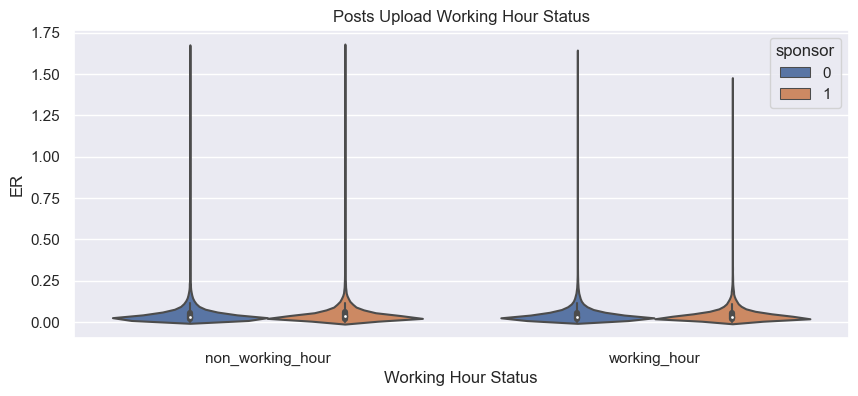

In [151]:
plt.figure(figsize=(10, 4))

ax = sns.violinplot(data=df, x='working_hour_status', y='ER', hue='sponsor')
    
ax.set(xlabel='Working Hour Status',
    ylabel='ER',
    title='Posts Upload Working Hour Status'
)
plt.show()

In [154]:
# Correlation between likes and comments
correlation1 = df['likes'].corr(df['comments'])
print(f"Correlation between likes and comments: {correlation1}")

# Correlation between ER and likes
correlation2 = df['ER'].corr(df['likes'])
print(f"Correlation between ER and likes: {correlation2}")

# Correlation between ER and comments
correlation3 = df['ER'].corr(df['comments'])
print(f"Correlation between ER and comments: {correlation3}")

#Posts

# Correlation between ER and #posts
correlation4 = df['ER'].corr(df['#Posts'])
print(f"Correlation between ER and #posts: {correlation4}")

Correlation between likes and comments: 0.3244651000466871
Correlation between ER and likes: 0.04307977566872101
Correlation between ER and comments: 0.1021403336992134
Correlation between ER and #posts: -0.2091289542763672


In [ ]:
df.to_csv('post_time_features.csv', lineterminator = "\r\n", index = False)

,post_timestamp,likes,comments,sponsor,ER,#Followers,json,year,month,day,hour,weekday,season,hour_category,working_hour_status
0,2018-05-13 14:43:40,172,11,0,0.058937,3105.0,1778527492682732179.json,2018,5,13,14,7,Spring,12-15,non_working_hour
1,2018-12-28 18:11:42,259,6,0,0.053676,4937.0,1944636038815427244.json,2018,12,28,18,5,Winter,18-21,non_working_hour
2,2018-11-23 20:27:39,3191,39,0,0.038740,83376.0,1919337317395337083.json,2018,11,23,20,5,Fall,18-21,non_working_hour
3,2019-02-06 20:09:40,3217,69,0,0.014540,225990.0,1973686443494832201.json,2019,2,6,20,3,Winter,18-21,non_working_hour
4,2018-01-08 10:07:47,1268,88,0,0.038791,34957.0,1687821871570856682.json,2018,1,8,10,1,Winter,9-12,working_hour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392849,2018-12-20 10:05:21,11094,18,0,0.047807,232436.0,1938593043369662682.json,2018,12,20,10,4,Winter,9-12,working_hour
392850,2019-03-19 07:24:01,547,20,0,0.005135,110414.0,2002986686942145187.json,2019,3,19,7,2,Spring,6-9,non_working_hour
392851,2018-09-13 07:14:08,451,80,0,0.058288,9110.0,1867448645486726111.json,2018,9,13,7,4,Fall,6-9,non_working_hour
392852,2017-02-27 07:10:16,187,29,0,0.018967,11388.0,1459428168212777165.json,2017,2,27,7,1,Winter,6-9,non_working_hour
